In [1]:
import os
import pickle
import utils
from datetime import datetime, timedelta
import gnss_tools.orbits as orbits
import gnss_tools.time as time
import gnss_tools.coords as coords
import utils.signals.gps_l1ca as gps_l1ca_utils
import numpy as np
import matplotlib.pyplot as plt

SPEED_OF_LIGHT = 299792458.0  # m/s

plt.rcParams.update({'font.size': 14})

In [2]:
# Get local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)

In [3]:
# Load the samples and sat params from simulation
output_filepath = os.path.join(data_dir, "simulated_gps_l1ca_signal_samples.npy")
assert os.path.exists(output_filepath), f"File {output_filepath} does not exist!"
samples = np.load(output_filepath)
samp_rate = 5e6  # Assuming 5 MHz sampling rate

params_filepath = os.path.join(data_dir, "simulated_gps_l1ca_signal_params.npy")
assert os.path.exists(params_filepath), f"File {params_filepath} does not exist!"
with open(params_filepath, "rb") as f:
    params = pickle.load(f)

sat_params = params["sat_params"]
samp_rate = params["samp_rate"]
samples_time_arr = np.arange(len(samples)) / samp_rate

sat_id_list = sorted(list(sat_params.keys()))
print(sat_id_list)

['G02', 'G05', 'G07', 'G08', 'G09', 'G13', 'G14', 'G17', 'G20', 'G21', 'G22', 'G30']


In [4]:
sat_id = "G02"
prn = int(sat_id[1:])
sat_info = sat_params[sat_id]
print((
    f"Satellite {sat_id} info:"
    f"  PRN: {prn}, C/N0: {sat_info['cn0_dBHz']:5.3f} dB-Hz, Doppler: {sat_info['initial_doppler_hz']:7.2f} Hz,"
    f"Initial code phase: {sat_info['initial_code_phase_chips'] % gps_l1ca_utils.CODE_LENGTH:8.3f} chips,"
    f"Initial carrier phase: {sat_info['initial_carrier_phase_rad'] % (2 * np.pi):7.3f} rad"
))

Satellite G02 info:  PRN: 2, C/N0: 27.268 dB-Hz, Doppler: 1977.06 Hz,Initial code phase:  823.663 chips,Initial carrier phase:   0.563 rad


In [5]:
def generate_l1ca_reference_samples(
        prn: int,
        samp_rate_hz: float,
        num_samples: int,
        initial_code_phase_chips: float,
        initial_carrier_phase_rad: float,
        doppler_hz: float,
        data_bits: np.ndarray | None = None,
) -> np.ndarray:
    """Generate reference samples for a given set of signal parameters."""
    time_arr = np.arange(num_samples) / samp_rate_hz

    # Generate code samples
    code_seq = 1 - 2 * gps_l1ca_utils.get_GPS_L1CA_code_sequence(prn).astype(np.int8)
    adjusted_code_rate = gps_l1ca_utils.CODE_RATE * (1 + doppler_hz / gps_l1ca_utils.CARRIER_FREQ)
    code_phase_chips = initial_code_phase_chips + time_arr * adjusted_code_rate
    code_chip_indices = code_phase_chips.astype(int) % gps_l1ca_utils.CODE_LENGTH
    code_samples = code_seq[code_chip_indices]

    # Generate carrier samples
    carrier_phase = initial_carrier_phase_rad + 2.0 * np.pi * doppler_hz * time_arr
    carrier_samples = np.exp(1j * carrier_phase)

    # Combine to form signal samples
    signal_samples = code_samples * carrier_samples

    if data_bits is not None:
        # Generate data samples
        code_phase_bits = code_phase_chips * gps_l1ca_utils.DATA_SYMBOL_RATE / gps_l1ca_utils.CODE_RATE
        data_bit_indices = code_phase_bits.astype(int) % len(data_bits)
        data_samples = data_bits[data_bit_indices]
        signal_samples = signal_samples * data_samples

    return signal_samples

In [6]:
reference_duration = 1e-3
num_reference_samples = int(reference_duration * samp_rate)
reference_samples = generate_l1ca_reference_samples(
    prn=prn,
    samp_rate_hz=samp_rate,
    num_samples=num_reference_samples,
    initial_code_phase_chips=sat_info["initial_code_phase_chips"],
    initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
    doppler_hz=sat_info["initial_doppler_hz"],
)

In [7]:
# fig = plt.figure(figsize=(12, 6))
# ax1, ax2 = fig.subplots(2, 1, sharex=True)
# _num_plot_samp = 500
# ax1.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.real(samples[:_num_plot_samp]), label="Real", color="r", marker="o")
# ax1.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.imag(samples[:_num_plot_samp]), label="Imag", color="b", marker="o")
# ax1.grid()
# ax1.set_ylabel("Baseband Samples")
# # ax1.set_xlabel("Time [µs]")

# ax2.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.real(reference_samples[:_num_plot_samp]), label="Real", color="r", marker="o")
# ax2.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.imag(reference_samples[:_num_plot_samp]), label="Imag", color="b", marker="o")
# ax2.grid()
# ax2.set_ylabel("Reference Samples")
# ax2.set_xlabel("Time [µs]")

# fig.align_labels()

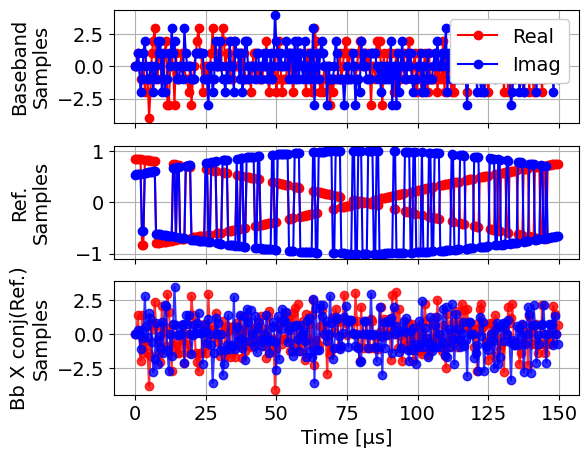

In [8]:
fig = plt.figure(figsize=(6, 5))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
_num_plot_samp = 300
ax1.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.real(samples[:_num_plot_samp]), label="Real", color="r", marker="o")
ax1.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.imag(samples[:_num_plot_samp]), label="Imag", color="b", marker="o")
ax1.grid()
ax1.set_ylabel("Baseband\nSamples")
# ax1.set_xlabel("Time [µs]")

ax2.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.real(reference_samples[:_num_plot_samp]), label="Real", color="r", marker="o")
ax2.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.imag(reference_samples[:_num_plot_samp]), label="Imag", color="b", marker="o")
ax2.grid()
ax2.set_ylabel("Ref.\nSamples")

_bb_conj_ref_samples = samples[:_num_plot_samp] * np.conj(reference_samples[:_num_plot_samp])
ax3.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.real(_bb_conj_ref_samples[:_num_plot_samp]), label="Real", color="r", marker="o", alpha=.8)
ax3.plot(samples_time_arr[:_num_plot_samp] * 1e6, np.imag(_bb_conj_ref_samples[:_num_plot_samp]), label="Imag", color="b", marker="o", alpha=.8)
ax3.grid()
ax3.set_ylabel("Bb X conj(Ref.)\nSamples")
ax3.set_xlabel("Time [µs]")

ax1.legend(framealpha=1.0, loc="upper right")

fig.align_labels()

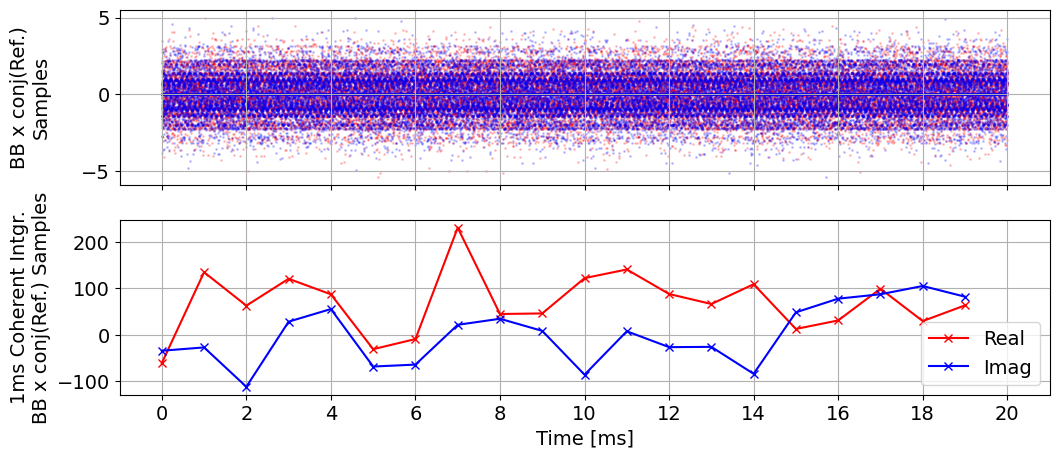

In [9]:
reference_duration_ms = 20
num_reference_samples = int(reference_duration_ms * 1e-3 * samp_rate)
num_coh_samples = int(1e-3 * samp_rate)  # 1 ms coherent integration
prn = int(sat_id[1:])
reference_samples = generate_l1ca_reference_samples(
    prn=prn,
    samp_rate_hz=samp_rate,
    num_samples=num_reference_samples,
    initial_code_phase_chips=sat_info["initial_code_phase_chips"],
    initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
    doppler_hz=sat_info["initial_doppler_hz"],
    data_bits=sat_info["data_bits"]
)

fig = plt.figure(figsize=(12, 5))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
_num_plot_samp = num_reference_samples

bb_conj_ref_samples = samples[:num_reference_samples] * np.conj(reference_samples)
coh_integrated_samples = np.sum(bb_conj_ref_samples.reshape((reference_duration_ms, -1)), axis=1)
_plot_time = samples_time_arr[:_num_plot_samp] * 1e3
ax1.scatter(_plot_time, np.real(bb_conj_ref_samples[:_num_plot_samp]), label="Real", color="r", s=1, alpha=.2)
ax1.scatter(_plot_time, np.imag(bb_conj_ref_samples[:_num_plot_samp]), label="Imag", color="b", s=1, alpha=.2)
ax1.grid()
ax1.set_ylabel("BB x conj(Ref.)\nSamples")

_plot_time = samples_time_arr[:_num_plot_samp:num_coh_samples] * 1e3
ax2.plot(_plot_time, np.real(coh_integrated_samples), label="Real", color="r", marker="x")
ax2.plot(_plot_time, np.imag(coh_integrated_samples), label="Imag", color="b", marker="x")
ax2.grid()
ax2.set_xticks(np.arange(0, reference_duration_ms + 1, 2))
ax2.set_ylabel("1ms Coherent Intgr.\nBB x conj(Ref.) Samples")
ax2.set_xlabel("Time [ms]")
ax2.legend(loc="lower right")

fig.align_labels()

In [10]:
sat_id = sat_id_list[4]
sat_info = sat_params[sat_id]
prn = int(sat_id[1:])
print((
    f"Satellite {sat_id} info:"
    f"  PRN: {prn}, C/N0: {sat_info['cn0_dBHz']:5.3f} dB-Hz, Doppler: {sat_info['initial_doppler_hz']:7.2f} Hz,"
    f"Initial code phase: {sat_info['initial_code_phase_chips'] % gps_l1ca_utils.CODE_LENGTH:8.3f} chips,"
    f"Initial carrier phase: {sat_info['initial_carrier_phase_rad'] % (2 * np.pi):7.3f} rad"
))

integration_durations_ms = [1, 2, 5, 10, 20]
doppler_offsets = np.arange(-5000, 5000 + 100, 100)  # Hz
correlations = np.zeros((len(integration_durations_ms), len(doppler_offsets)), dtype=complex)

for i, duration_ms in enumerate(integration_durations_ms):
    num_reference_samples = int((duration_ms * 1e-3) * samp_rate)
    for j, doppler in enumerate(doppler_offsets):
        dopp_shifted_reference_samples = generate_l1ca_reference_samples(
            prn=prn,
            samp_rate_hz=samp_rate,
            num_samples=num_reference_samples,
            initial_code_phase_chips=sat_info["initial_code_phase_chips"],
            initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
            doppler_hz=doppler,
        )
        correlations[i, j] = np.sum(samples[:len(dopp_shifted_reference_samples)] * np.conj(dopp_shifted_reference_samples))

Satellite G09 info:  PRN: 9, C/N0: 40.318 dB-Hz, Doppler: -3142.68 Hz,Initial code phase:  281.830 chips,Initial carrier phase:   1.295 rad


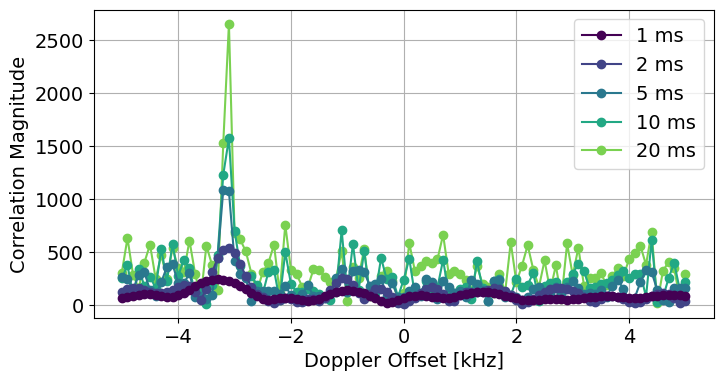

In [11]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.subplots(1, 1)
for i, duration_ms in enumerate(integration_durations_ms):
    color = plt.cm.viridis(i / len(integration_durations_ms))
    ax1.plot(doppler_offsets / 1e3, np.abs(correlations[i, :]), marker="o", label=f"{duration_ms} ms", color=color, zorder=10 - i)

ax1.set_xlabel("Doppler Offset [kHz]")
ax1.set_ylabel("Correlation Magnitude")
ax1.legend()
ax1.grid()
plt.show()

In [12]:
sat_id = sat_id_list[2]
sat_info = sat_params[sat_id]
prn = int(sat_id[1:])
print((
    f"Satellite {sat_id} info:"
    f"  PRN: {prn}, C/N0: {sat_info['cn0_dBHz']:5.3f} dB-Hz, Doppler: {sat_info['initial_doppler_hz']:7.2f} Hz,"
    f"Initial code phase: {sat_info['initial_code_phase_chips'] % gps_l1ca_utils.CODE_LENGTH:8.3f} chips,"
    f"Initial carrier phase: {sat_info['initial_carrier_phase_rad'] % (2 * np.pi):7.3f} rad"
))

integration_durations_ms = [1, 2, 5, 10, 20]
code_chip_offsets = np.arange(-5, 5, .1)  # chips
correlations = np.zeros((len(integration_durations_ms), len(code_chip_offsets)), dtype=complex)

for i, duration_ms in enumerate(integration_durations_ms):
    num_reference_samples = int((duration_ms * 1e-3) * samp_rate)
    for j, chip_offset in enumerate(code_chip_offsets):
        code_shifted_reference_samples = generate_l1ca_reference_samples(
            prn=prn,
            samp_rate_hz=samp_rate,
            num_samples=num_reference_samples,
            initial_code_phase_chips=sat_info["initial_code_phase_chips"] + chip_offset,
            initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
            doppler_hz=sat_info["initial_doppler_hz"],
        )
        correlations[i, j] = np.sum(samples[:len(code_shifted_reference_samples)] * np.conj(code_shifted_reference_samples))

Satellite G07 info:  PRN: 7, C/N0: 49.935 dB-Hz, Doppler: -122.96 Hz,Initial code phase:  998.257 chips,Initial carrier phase:   1.338 rad


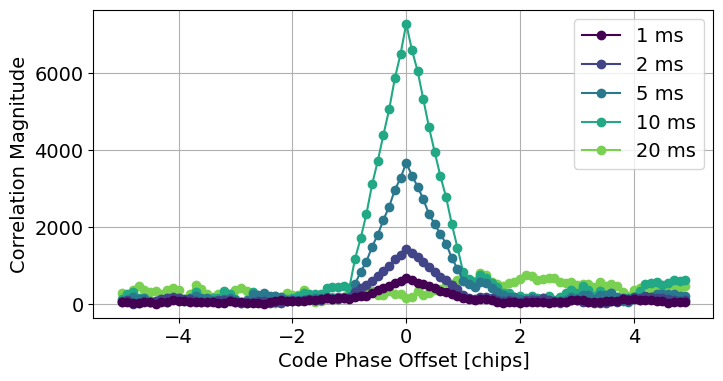

In [13]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.subplots(1, 1)
for i, duration_ms in enumerate(integration_durations_ms):
    color = plt.cm.viridis(i / len(integration_durations_ms))
    ax1.plot(code_chip_offsets, np.abs(correlations[i, :]), marker="o", label=f"{duration_ms} ms", color=color, zorder=10 - i)

ax1.set_xlabel("Code Phase Offset [chips]")
ax1.set_ylabel("Correlation Magnitude")
ax1.legend()
ax1.grid()
plt.show()

Satellite G09 info:  PRN: 9, C/N0: 40.318 dB-Hz, Doppler: -3142.68 Hz,Initial code phase:  281.830 chips,Initial carrier phase:   1.295 rad
 1  SNR: 17.14 dB
    Processing Gain: 33.01 dB
    Estimated input SNR: -15.87 dB
    Estimated C/N0: 47.14 dB-Hz
    Expected C/N0: 40.32 dB-Hz
    Difference: 6.82 dB-Hz
 5  SNR: 20.85 dB
    Processing Gain: 40.00 dB
    Estimated input SNR: -19.15 dB
    Estimated C/N0: 43.86 dB-Hz
    Expected C/N0: 40.32 dB-Hz
    Difference: 3.54 dB-Hz
 10  SNR: 23.61 dB
    Processing Gain: 43.01 dB
    Estimated input SNR: -19.40 dB
    Estimated C/N0: 43.61 dB-Hz
    Expected C/N0: 40.32 dB-Hz
    Difference: 3.30 dB-Hz


(0.0, 2000.0)

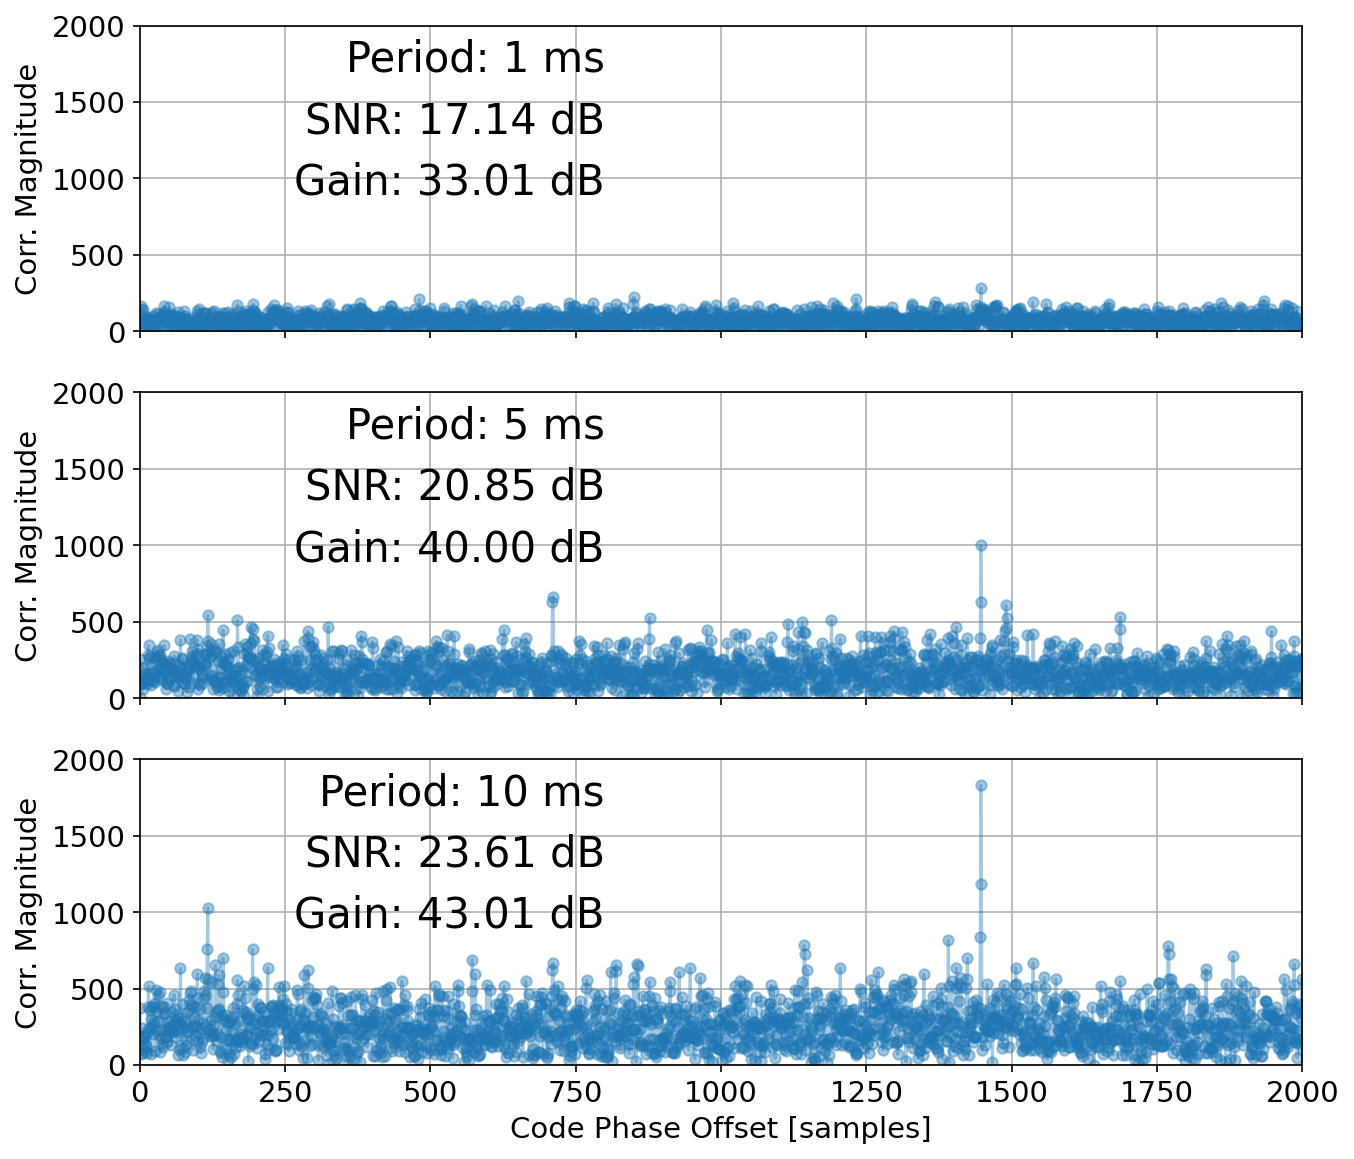

In [14]:
sat_id = sat_id_list[4]
sat_info = sat_params[sat_id]
prn = int(sat_id[1:])
print((
    f"Satellite {sat_id} info:"
    f"  PRN: {prn}, C/N0: {sat_info['cn0_dBHz']:5.3f} dB-Hz, Doppler: {sat_info['initial_doppler_hz']:7.2f} Hz,"
    f"Initial code phase: {sat_info['initial_code_phase_chips'] % gps_l1ca_utils.CODE_LENGTH:8.3f} chips,"
    f"Initial carrier phase: {sat_info['initial_carrier_phase_rad'] % (2 * np.pi):7.3f} rad"
))

coh_integr_durations_ms = [1, 5, 10]
num_samples_1ms = int(1e-3 * samp_rate)
correlations = {}
snrs_out_est = {}
_offset = num_samples_1ms

for coh_integr_duration_ms in coh_integr_durations_ms:

    num_coh_samples = int(coh_integr_duration_ms * 1e-3 * samp_rate)
    num_reference_samples = num_coh_samples
    reference_samples = generate_l1ca_reference_samples(
        prn=prn,
        samp_rate_hz=samp_rate,
        num_samples=num_reference_samples,
        initial_code_phase_chips=0.0,
        # initial_code_phase_chips=sat_info["initial_code_phase_chips"],
        initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
        doppler_hz=sat_info["initial_doppler_hz"],
        # data_bits=sat_info["data_bits"]
    )
    xcorr = np.fft.ifft(np.fft.fft(samples[_offset:_offset + num_reference_samples]) * np.conj(np.fft.fft(reference_samples)))
    xcorr_var = np.var(np.abs(xcorr))
    correlations[coh_integr_duration_ms] = xcorr

    snr_out_est = np.max(np.abs(xcorr)**2 - xcorr_var) / xcorr_var
    snr_out_est_dB = 10 * np.log10(snr_out_est)
    print(f"{coh_integr_duration_ms: 2}  SNR: {snr_out_est_dB:.2f} dB")
    processing_gain_dB = 10 * np.log10(samp_rate * coh_integr_duration_ms * 1e-3)
    snr_in_dB_est = snr_out_est_dB - processing_gain_dB
    print(f"    Processing Gain: {processing_gain_dB:.2f} dB")
    print(f"    Estimated input SNR: {snr_in_dB_est:.2f} dB")
    cn0_dBHz_est = snr_in_dB_est + 10 * np.log10(samp_rate)
    print(f"    Estimated C/N0: {cn0_dBHz_est:.2f} dB-Hz")
    print(f"    Expected C/N0: {sat_info['cn0_dBHz']:.2f} dB-Hz")
    print(f"    Difference: {cn0_dBHz_est - sat_info['cn0_dBHz']:.2f} dB-Hz")

    snrs_out_est[coh_integr_duration_ms] = snr_out_est

fig = plt.figure(figsize=(10, 9), dpi=150)
axes = fig.subplots(3, 1, sharex=True)
ax1, ax2, ax3 = axes

for i, coh_integr_duration_ms in enumerate(coh_integr_durations_ms):
    ax = axes[i]
    xcorr = correlations[coh_integr_duration_ms]
    # color = plt.cm.viridis(coh_integr_duration_ms / max(coh_integr_durations_ms))
    ax.plot(np.arange(len(xcorr)), np.abs(xcorr), marker="o", alpha=.4, markersize=5)
    ax.text(0.4, 0.85, f"Period: {coh_integr_duration_ms} ms",
            fontsize=20, transform=ax.transAxes, horizontalalignment='right')
    ax.text(0.4, 0.65, f"SNR: {10 * np.log10(snrs_out_est[coh_integr_duration_ms]):.2f} dB",
            fontsize=20, transform=ax.transAxes, horizontalalignment='right')
    processing_gain_dB = 10 * np.log10(samp_rate * coh_integr_duration_ms * 1e-3)
    ax.text(0.4, 0.45, f"Gain: {processing_gain_dB:.2f} dB",
            fontsize=20, transform=ax.transAxes, horizontalalignment='right')
    ax.grid()
    ax.set_ylabel("Corr. Magnitude")
    ax.set_ylim(0, 2000)
ax3.set_xlabel("Code Phase Offset [samples]")
ax3.set_xlim(0, num_samples_1ms)

In [15]:
for sat_id in sat_id_list:
    sat_info = sat_params[sat_id]
    prn = int(sat_id[1:])
    print((
        f"Satellite {sat_id} info:"
        f"  PRN: {prn}, C/N0: {sat_info['cn0_dBHz']:5.3f} dB-Hz, Doppler: {sat_info['initial_doppler_hz']:7.2f} Hz,"
        f"Initial code phase: {sat_info['initial_code_phase_chips'] % gps_l1ca_utils.CODE_LENGTH:8.3f} chips,"
        f"Initial carrier phase: {sat_info['initial_carrier_phase_rad'] % (2 * np.pi):7.3f} rad"
    ))

Satellite G02 info:  PRN: 2, C/N0: 27.268 dB-Hz, Doppler: 1977.06 Hz,Initial code phase:  823.663 chips,Initial carrier phase:   0.563 rad
Satellite G05 info:  PRN: 5, C/N0: 30.070 dB-Hz, Doppler: -506.31 Hz,Initial code phase:  727.210 chips,Initial carrier phase:   6.167 rad
Satellite G07 info:  PRN: 7, C/N0: 49.935 dB-Hz, Doppler: -122.96 Hz,Initial code phase:  998.257 chips,Initial carrier phase:   1.338 rad
Satellite G08 info:  PRN: 8, C/N0: 37.283 dB-Hz, Doppler: -2239.51 Hz,Initial code phase:  748.307 chips,Initial carrier phase:   2.829 rad
Satellite G09 info:  PRN: 9, C/N0: 40.318 dB-Hz, Doppler: -3142.68 Hz,Initial code phase:  281.830 chips,Initial carrier phase:   1.295 rad
Satellite G13 info:  PRN: 13, C/N0: 32.118 dB-Hz, Doppler: 3327.25 Hz,Initial code phase:  848.252 chips,Initial carrier phase:   4.219 rad
Satellite G14 info:  PRN: 14, C/N0: 47.989 dB-Hz, Doppler: 1332.96 Hz,Initial code phase:  713.496 chips,Initial carrier phase:   2.389 rad
Satellite G17 info:  PR

In [16]:
cn0_dBHz = 44.1
snr_in_dB = cn0_dBHz - 10 * np.log10(samp_rate)
snr_out_dB = snr_in_dB + 10 * np.log10(1000)
print(f"SNR in: {snr_in_dB:.2f} dB, SNR out (1 ms): {snr_out_dB:.2f} dB")

SNR in: -18.91 dB, SNR out (1 ms): 11.09 dB


In [23]:
snr_out_est_dB = 21.6
snr_out_est = 10**(snr_out_est_dB / 10)
bandwidth_hz = 1e3
cn0_dBHz = 10 * np.log10(snr_out_est * bandwidth_hz)
print(f"C/N0: {cn0_dBHz:.2f} dB-Hz")

C/N0: 51.60 dB-Hz


In [24]:
total_integration_duration_ms = 40

sat_id = sat_id_list[4]
sat_info = sat_params[sat_id]
prn = int(sat_id[1:])

print(f"Sat ID: {sat_id}, PRN: {prn}, Initial Code Phase (chips): {sat_info['initial_code_phase_chips']}, Initial Carrier Phase (rad): {sat_info['initial_carrier_phase_rad']}")
print(f"Initial Doppler (Hz): {sat_info['initial_doppler_hz']}, C/N0 (dB-Hz): {sat_info['cn0_dBHz']}")

integration_durations_ms = [1, 2, 5, 10, 20]
doppler_offsets = np.arange(-5000, 5000 + 100, 100)  # Hz
correlations = np.zeros((len(integration_durations_ms), len(doppler_offsets)), dtype=complex)

for i, duration_ms in enumerate(integration_durations_ms):
    num_ncoherent_integrations = total_integration_duration_ms // duration_ms
    num_coh_samples = int((duration_ms * 1e-3) * samp_rate)
    num_reference_samples = num_coh_samples * num_ncoherent_integrations
    for j, doppler in enumerate(doppler_offsets):
        reference_samples = generate_l1ca_reference_samples(
            prn=prn,
            samp_rate_hz=samp_rate,
            num_samples=num_reference_samples,
            initial_code_phase_chips=sat_info["initial_code_phase_chips"],
            initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
            doppler_hz=doppler,
        )
        coh_integrations = np.sum((samples[:len(reference_samples)] * np.conj(reference_samples)).reshape((num_ncoherent_integrations, num_coh_samples)), axis=1)
        correlations[i, j] = np.sum(np.abs(coh_integrations)**2, axis=0)

Sat ID: G09, PRN: 9, Initial Code Phase (chips): -75420.16999598408, Initial Carrier Phase (rad): -729773512.1349809
Initial Doppler (Hz): -3142.6808605461433, C/N0 (dB-Hz): 40.318137783614915


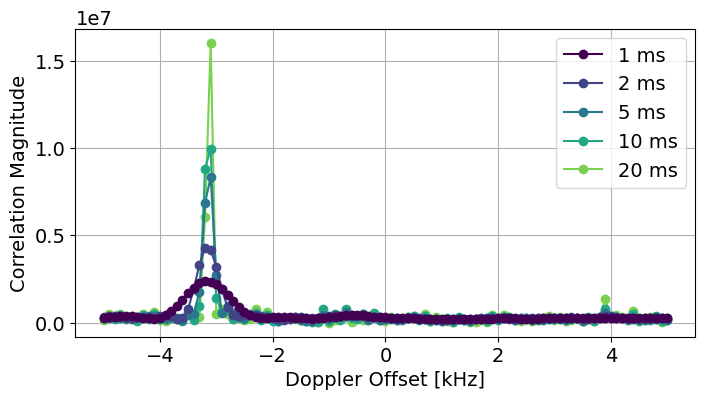

In [25]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.subplots(1, 1)
for i, duration_ms in enumerate(integration_durations_ms):
    color = plt.cm.viridis(i / len(integration_durations_ms))
    ax1.plot(doppler_offsets / 1e3, np.abs(correlations[i, :]), marker="o", label=f"{duration_ms} ms", color=color, zorder=10 - i)

ax1.set_xlabel("Doppler Offset [kHz]")
ax1.set_ylabel("Correlation Magnitude")
ax1.legend()
ax1.grid()
plt.show()

In [26]:
total_integration_duration_ms = 40

sat_id = sat_id_list[4]
sat_info = sat_params[sat_id]
prn = int(sat_id[1:])

print(f"Sat ID: {sat_id}, PRN: {prn}, Initial Code Phase (chips): {sat_info['initial_code_phase_chips']}, Initial Carrier Phase (rad): {sat_info['initial_carrier_phase_rad']}")
print(f"Initial Doppler (Hz): {sat_info['initial_doppler_hz']}, C/N0 (dB-Hz): {sat_info['cn0_dBHz']}")

integration_durations_ms = [1, 2, 5, 10, 20]
num_ncoh_integrations = [total_integration_duration_ms // d for d in integration_durations_ms]
num_reference_samples = int((total_integration_duration_ms * 1e-3) * samp_rate)
code_chip_offsets = np.arange(-15, 15, .1)  # chips
correlations = np.zeros((len(integration_durations_ms), len(code_chip_offsets)), dtype=complex)

for i, duration_ms in enumerate(integration_durations_ms):
    num_ncoherent_integrations = num_ncoh_integrations[i]
    num_coh_samples = int((duration_ms * 1e-3) * samp_rate)
    for j, chip_offset in enumerate(code_chip_offsets):
        reference_samples = generate_l1ca_reference_samples(
            prn=prn,
            samp_rate_hz=samp_rate,
            num_samples=num_reference_samples,
            initial_code_phase_chips=sat_info["initial_code_phase_chips"] + chip_offset,
            initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
            doppler_hz=sat_info["initial_doppler_hz"],
        )
        coh_integrations = np.sum((samples[:len(reference_samples)] * np.conj(reference_samples)).reshape((num_ncoherent_integrations, num_coh_samples)), axis=1)
        correlations[i, j] = np.sum(np.abs(coh_integrations)**2, axis=0)

Sat ID: G09, PRN: 9, Initial Code Phase (chips): -75420.16999598408, Initial Carrier Phase (rad): -729773512.1349809
Initial Doppler (Hz): -3142.6808605461433, C/N0 (dB-Hz): 40.318137783614915


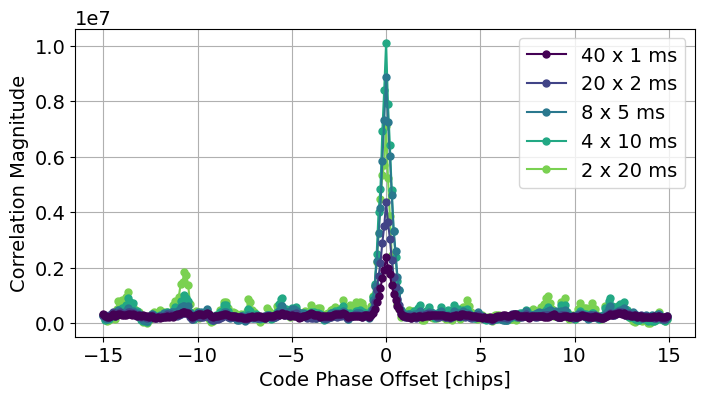

In [27]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.subplots(1, 1)
for i, duration_ms in enumerate(integration_durations_ms):
    num_ncoh = num_ncoh_integrations[i]
    color = plt.cm.viridis(i / len(integration_durations_ms))
    ax1.plot(code_chip_offsets, np.abs(correlations[i, :]), marker="o", label=f"{num_ncoh} x {duration_ms} ms", color=color, markersize=5, zorder=10 - i)

ax1.set_xlabel("Code Phase Offset [chips]")
ax1.set_ylabel("Correlation Magnitude")
ax1.legend()
ax1.grid()
plt.show()

Sat ID: G09, PRN: 9, Initial Code Phase (chips): -75420.16999598408, Initial Carrier Phase (rad): -729773512.1349809
Initial Doppler (Hz): -3142.6808605461433, C/N0 (dB-Hz): 40.318137783614915
SNR: 20.56 dB


(0.0, 1500.0)

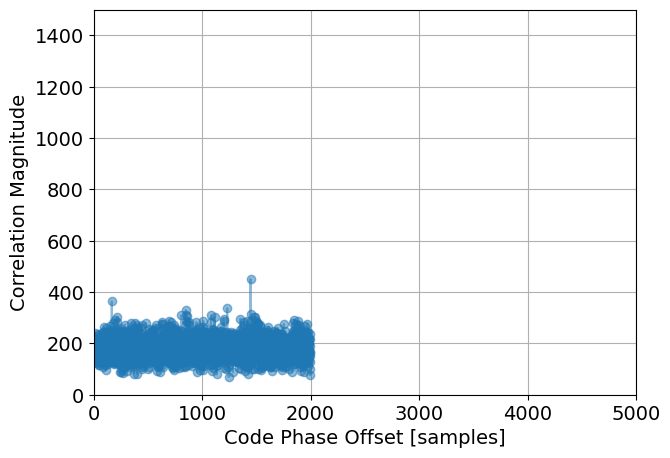

In [28]:
sat_id = sat_id_list[4]
sat_info = sat_params[sat_id]
prn = int(sat_id[1:])

print(f"Sat ID: {sat_id}, PRN: {prn}, Initial Code Phase (chips): {sat_info['initial_code_phase_chips']}, Initial Carrier Phase (rad): {sat_info['initial_carrier_phase_rad']}")
print(f"Initial Doppler (Hz): {sat_info['initial_doppler_hz']}, C/N0 (dB-Hz): {sat_info['cn0_dBHz']}")

fig = plt.figure(figsize=(7, 5))

coh_duration_ms = 1
num_ncoh = 5
num_reference_samples = int(coh_duration_ms * 1e-3 * samp_rate)

reference_samples = generate_l1ca_reference_samples(
    prn=prn,
    samp_rate_hz=samp_rate,
    num_samples=num_reference_samples,
    initial_code_phase_chips=0.0,
    initial_carrier_phase_rad=sat_info["initial_carrier_phase_rad"],
    doppler_hz=sat_info["initial_doppler_hz"],
)
xcorr = np.fft.ifft(np.fft.fft(samples[:num_reference_samples * num_ncoh].reshape((num_ncoh, -1)), axis=-1) * np.conj(np.fft.fft(reference_samples))[None, :], axis=1)
xcorr = np.sqrt(np.sum(np.abs(xcorr)**2, axis=0))

snr_out_est = np.max(np.abs(xcorr)) / np.std(np.abs(xcorr))
print(f"SNR: {20 * np.log10(snr_out_est):.2f} dB")

ax1 = fig.subplots(1, 1)
ax1.plot(np.arange(len(xcorr)), np.abs(xcorr), marker="o", alpha=.5)
ax1.grid()
ax1.set_ylabel("Correlation Magnitude")
ax1.set_xlabel("Code Phase Offset [samples]")
ax1.set_xlim(0, 5000)
ax1.set_ylim(0, 1500)